In [1]:
import sys
!{sys.executable} -m pip install trulens
!{sys.executable} -m pip install matplotlib

# Attributions

## Model Wrappers

In order to support a wide variety of backends with different interfaces for their respective models, TruLens uses its own `ModelWrapper` class which provides a general model interface to simplify the implementation of the API functions.
To get the model wrapper, use the `get_model_wrapper` method in `trulens.nn.models`. A model wrapper class exists for each backend that converts a model in the respective backend's format to the general TruLens `ModelWrapper` interface. The wrappers are found in the `models` module, and any model defined using Keras, Pytorch, or Tensorflow should be wrapped before being used with the other API functions that require a model -- all other TruLens functionalities expect models to be an instance of `trulens.nn.models.ModelWrapper`.

For more details on allowed parameters, see the [get_model_wrapper](https://truera.github.io/trulens/api/model_wrappers/) documentation.

For this demo, we will be using a Pytorch model pre-trained on Imagenet. 

In [1]:
import torch
# import torchvision.models as models
# import torchvision.transforms as transforms
import numpy as np

from trulens.nn.models import get_model_wrapper

import numpy as np
import matplotlib.pyplot as plt
import PIL

%matplotlib inline

In [2]:
import os
from pathlib import Path
import random
import pandas as pd
import json

from typing import List

from pathlib import Path
import torch
import torch.nn as nn
from torchtext.data import get_tokenizer

class ToySentiment(nn.Module):
    @staticmethod
    def from_pretrained(model_code_path: Path) -> 'ToySentiment':
        # Not strictly necessary to load or save given fixed parameters can be populated, but 
        # implementing this for better integration testing.
        model = ToySentiment()
        model.load_state_dict(torch.load(model_code_path))

    def to_pretrained(self, model_code_path: Path) -> None:
        torch.save(self.state_dict(), model_code_path)

    def set_parameters(self) -> None:
        """Set model parameters as per fixed specification."""

        Wi = torch.zeros_like(self.lstm.weight_ih_l0)
        bi = torch.zeros_like(self.lstm.bias_ih_l0)
        Wh = torch.zeros_like(self.lstm.weight_hh_l0)
        bh = torch.zeros_like(self.lstm.bias_hh_l0)

        big = 1000.0 # Multipliers to help dealing with LSTM sigmoids.
        half = 400.0 # Intention here is that sigmoid((x*big) - half) is ~0 if x is ~0; and
                     # ~1 when indicator is >~ 1.

        hs = self.hidden_size

        sneutral = 0
        sgood = 1
        sbad = 2
        sconfused = 3

        wneutral = self.vocab['neutral']
        wgood = self.vocab['good']
        wbad = self.vocab['bad']
        
        # make sure c gate is always big
        bi[0:hs*3] = 50
        bh[0:hs*3] = 50

        # o gate weights:
        Wi[3*hs,   wneutral] = big # read neutral word
        Wi[3*hs+1, wgood] = big # read good word
        Wi[3*hs+2, wbad] = big # read bad word
        Wh[3*hs,   sneutral] = big # keep prior neutral, good, bad states
        Wh[3*hs+1, sgood] = big # 
        Wh[3*hs+2, sbad] = big #
        bi[3*hs:4*hs] = -half # sigmoid will be 0 unless one of the three words was read

        # set "good to bad" confused if prior was good, and input was bad
        Wh[3*hs+3, sgood] = big    # (prior state was good
        Wi[3*hs+3, wbad] = big    #  and input was bad)
        Wh[3*hs+3, sconfused] = 2*big  # or (was already in this confused state)
        bh[3*hs+3] = -(half*2) # Want at least 2 of first two to fire, or just the last one to fire.

        # set "bad to good" confused if prior was bad, and input was good
        Wh[3*hs+4, sbad] = big     # (prior state was bad
        Wi[3*hs+4, wgood] = big     #  and input was good)
        Wh[3*hs+4, sconfused] = 2*big   # or (was already confused)
        bh[3*hs+4] = -(half*2)  #

        self.lstm.weight_hh_l0 = nn.Parameter(Wh)
        self.lstm.bias_hh_l0 = nn.Parameter(bh)
        self.lstm.weight_ih_l0 = nn.Parameter(Wi)
        self.lstm.bias_ih_l0 = nn.Parameter(bi)

        self.embedding.weight = nn.Parameter(torch.eye(self.emb_size))

        self.lin.weight = nn.Parameter(torch.tensor(
            [
                [10.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 20.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 20.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 30.0, 30.0]
            ]
        ))

    def __init__(self):
        super().__init__()
        
        self.tokenizer = get_tokenizer("basic_english")

        self.vocab = {"[UNKNOWN]": 0, "neutral": 1, "good": 2, "bad": 3}

        self.emb_size = len(self.vocab)

        self.hidden_size = 5
        # 5 states, one for neutral, one for positive, one for negative, and two for confused. Requiring two
        # confused states for simplicity of the model; it is easier to encode semantics of confusion based on 
        # which initial positive/negative state was set first.

        # Identity embedding, each vocab word has its own dimension where its presence is encoded.
        self.embedding = nn.Embedding(
            padding_idx=0, 
            embedding_dim=self.emb_size, 
            num_embeddings=self.emb_size
        )

        self.lstm = nn.LSTM(
            input_size=self.emb_size,
            hidden_size=self.hidden_size,
            num_layers=1,
            batch_first=True
        )

        # Linear layer to combine the two types of confused state and weight things so that
        # confused outweighs positive and negative, while positive and negative outweigh neutral 
        # if more than one of these states is set.
        self.lin = torch.nn.Linear(
            in_features=self.hidden_size,
            out_features=4,
            bias=False
        )

        # Finally add a softmax for classification.
        self.softmax = torch.nn.Softmax(dim=2)

        self.set_parameters()

    def forward(self, word_ids: torch.Tensor) -> torch.Tensor:
        batch_size = word_ids.shape[0]
        h0 = torch.zeros(1, batch_size, self.hidden_size)
        h0[0,0,0] = 1.0 # initial state is neutral
        c0 = torch.zeros(1, batch_size, self.hidden_size)

        embeds = self.embedding(word_ids)
        _, (hn, _) = self.lstm(embeds, (h0, c0))

        return self.softmax(self.lin(hn))

    def input_of_text(self, texts: List[str]) -> torch.Tensor:
        tokens = [self.tokenizer(text) for text in texts]

        word_ids = [[(self.vocab[t] if t in self.vocab else 0) for token in tokens for t in token]]

        return torch.Tensor(word_ids).int()


def generate_dataset(n, l):
    """Generate random sentiment sentences and their labels."""

    ret = []
    cls = []
    for i in range(n):
        sent = []
        while len(sent) < l:
            r = random.random()

            word = "neutral"

            if r > 0.9 and len(sent) > 0:
                continue
            elif r > 0.8:
                word = "good"
            elif r > 0.7:
                word = "bad"

            sent.append(word)

        ret.append(" ".join(sent))

        gt = 0 # neutral
        if "good" in sent and "bad" in sent:
            gt = 3 # confused
        elif "good" in sent:
            gt = 1 # positive
        elif "bad" in sent:
            gt = 2 # negative

        cls.append(gt)

    return pd.DataFrame(dict(sentence=ret, sentiment=cls))

In [3]:
test_data = generate_dataset(1000, 16)
test_data

,sentence,sentiment
0,neutral bad neutral neutral neutral neutral ne...,3
1,neutral neutral neutral neutral neutral neutra...,3
2,neutral neutral bad neutral neutral neutral ne...,3
3,neutral neutral neutral neutral neutral neutra...,2
4,bad bad neutral neutral neutral neutral neutra...,2
...,...,...
995,neutral neutral neutral neutral neutral neutra...,3
996,good neutral neutral neutral bad neutral neutr...,3
997,neutral neutral neutral bad bad bad neutral ne...,3
998,good neutral neutral neutral neutral neutral n...,3


In [4]:
pytorch_model = ToySentiment()


device = 'cpu'
# Produce a wrapped model from the pytorch model.
model = get_model_wrapper(pytorch_model, input_shape=(16), device=device, input_dtype=int)

INFO: lib level=1
INFO: root level=30
INFO: Detected pytorch backend for <class '__main__.ToySentiment'>.
INFO: Changing backend from None to Backend.PYTORCH.
INFO: If this seems incorrect, you can force the correct backend by passing the `backend` parameter directly into your get_model_wrapper call.


In [5]:
model.print_layer_names()

'embedding':	Embedding(4, 4, padding_idx=0)
'lstm':	LSTM(4, 5, batch_first=True)
'lin':	Linear(in_features=5, out_features=4, bias=False)
'softmax':	Softmax(dim=2)


In [9]:
m = ToySentiment()

test_data = generate_dataset(10, 16)

for sentence, sentiment in zip(test_data['sentence'], test_data['sentiment']):
    word_ids = m.input_of_text([sentence])
    out = m(word_ids)
    print(sentence, "\t", word_ids, "\t", "prediction=", torch.argmax(out), "\t", "label=", sentiment)

neutral neutral neutral good neutral neutral good neutral neutral neutral good neutral neutral neutral neutral neutral 	 tensor([[1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1]], dtype=torch.int32) 	 prediction= tensor(1) 	 label= 1
neutral neutral bad neutral neutral bad good neutral good neutral good neutral neutral bad neutral neutral 	 tensor([[1, 1, 3, 1, 1, 3, 2, 1, 2, 1, 2, 1, 1, 3, 1, 1]], dtype=torch.int32) 	 prediction= tensor(3) 	 label= 3
neutral neutral neutral neutral good neutral neutral neutral good neutral neutral bad bad neutral neutral bad 	 tensor([[1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 3, 3, 1, 1, 3]], dtype=torch.int32) 	 prediction= tensor(3) 	 label= 3
neutral neutral bad neutral neutral neutral neutral neutral neutral neutral neutral good neutral neutral neutral neutral 	 tensor([[1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1]], dtype=torch.int32) 	 prediction= tensor(1) 	 label= 3
neutral bad neutral good good neutral neutral neutral neutral neutral bad good neut

Now that we've loaded our model, lets take a quick look at its predictions on the following record:

In the next section, we'll show how to use the TruLens API to further investigate the model's predictions on this record.

## Attribution Methods

*Attribution methods*, in the most general sense, allow us to quantify the contribution of particular variables in a model towards a particular behavior of the model. 
In many cases, for example, this may simply measure the effect each input variable has on the output of the network.

Attribution methods extend the `AttributionMethod` class, and many concrete instances are found in the `attribution` module.

Once an attribution method has been instantiated, its main function is its `attributions` method, which takes an `np.Array` of batched records, where each record matches the shape of the input to the model the attribution method was instantiated with.
In this demo, we will mostly make use of the `InternalInfluence` attribution method, as it is the most general, though we will compare it briefly with the other methods.

### Getting started: Saliency Maps and Integrated Gradients

The first methods that we will examine directly measure the importance of input features on the classification of the model. These are the most straightforward type of attributions to compute, as there are relatively few choices to make.

* _Saliency maps_ take the gradient of the network's predicted class on a given input. See the reference by Simonyan et al. given below for more details and discussion of this method.
* _Integrated gradients_ addresses some issues with saliency maps described by Sundararajan et al., and proposes a way of addressing them by aggregating the gradient on a linear subspace of the model's input features. Because this aggregation cannot be computed exactly in general, the implementation evaluates the gradient on a specified number of samples.

We will see how to use each of these methods using the API, and how to visualize the results.

---
Karen Simonyan, Andrea Vedaldi, Andrew Zisserman. *Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps*. ICLR 2014. [ArXiv](https://arxiv.org/pdf/1312.6034.pdf)

Mukund Sundararajan, Ankur Taly, Qiqi Yan. *Axiomatic Attribution for Deep Networks* [PMLR](http://proceedings.mlr.press/v70/sundararajan17a/sundararajan17a.pdf)


In [8]:
from trulens.nn.attribution import InputAttribution
from trulens.nn.attribution import IntegratedGradients

Saliency maps are implemented by the `InputAttribution` class. This takes several optional arguments, the meaning of which we will discuss later in this notebook. The provided defaults instantiate an `AttributionMethod` that is consistent with the method described in the reference above.

The required argument to the constructor is a `ModelWrapper`. After constructing the attribution method, we call it on our data point, and receive an array containing the attributions.

In [9]:
infl = InputAttribution(model)
attrs_input = infl.attributions(x_pp)

To visualize the attributions, we can use `MaskVisualizer` from the `visualizations` module. This class takes a `blur` and `threshold` argument, and allows us to overlay a partially-opaque mask over a given image that reveals the top-threshold percentage of pixels by attribution, after applying a Gaussian blur of the given radius.

In [10]:
from trulens.visualizations import MaskVisualizer

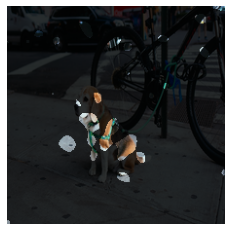

In [11]:
masked_image = MaskVisualizer(blur=5, threshold=0.95)(attrs_input, x)

Turning to Integrated Gradients, the workflow for obtaining attributions is nearly identical. The only difference is that the `AttributionMethod` instance we construct is one of `IntegratedGradients` rather than `InputGradients`.

The `resolution` argument, which is optional and defaults to 50, specifies the number of samples to take. Larger values approximate the true aggregate quantity more closely, and in practical terms, tend to be more stable.

Another optional argument is the `baseline`, which specifies the linear subspace over which the quantity is aggregated. By default this is `None`, which is interpreted as an appropriately-sized zero tensor. In this case the linear subspace is the line between this zero tensor, and the point for which the attributions are computed.

In [12]:
infl = IntegratedGradients(model, resolution=10)
attrs_input = infl.attributions(x_pp)

/home/piotrm/anaconda3/envs/python37_notebooks_latest/lib/python3.7/site-packages/torch/cuda/__init__.py:143: UserWarning: 
NVIDIA GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

Visualizing the results, it is apparent that Integrated Gradients in this case is better able to focus on the pixels corresponding to the beagle, which is consistent with the model's top predicted class.

In [ ]:
masked_image = MaskVisualizer(blur=5, threshold=0.95)(attrs_input, x)

### Discovering Important Internal Neurons 

Now we'll examine is *Internal Influence* (Leino et al.), a powerful and general attribution method that can calculate attributions for internal neurons in a network as well as for the inputs to the network. Internal Influence is implemented by the `InternalInfluence` class in the `attribution` module.

The `InternalInfluence` constructor takes a TruLens `ModelWrapper` and three special parameters: a *slice*, a *quantity of interest* (QoI), and a *distribution of interest* (DoI), which are instances of the `Slice` (in the `slices` module), `QoI` (in the `quantities` module), and `DoI` (in the `distributions` module) classes, respectively.

The slice essentially defines a layer to use for internal attributions. A `Slice` object specifies two `Cut`s corresponding to two layers: (1) the layer of the variables that we are calculating attribution *for* (e.g., the input layer), and (2) the layer whose output defines our quantity of interest (e.g., the output layer; see below for more on quantities of interest).

The shape of the attributions will always match the shape of the first cut. In the case of `InputAttribution`, it is the shape of the input. For neuron explanations, the attributions can take the shape of the output or input of a specific network layer. The default behavior is to create attributions for the output of a layer, but this can be specified via the `anchor` in the `Cut` class. See the [Slice](https://truera.github.io/trulens/api/slices/) documentation for more detail.

The quantity of interest (QoI) essentially defines the model behavior we would like to explain using attributions. The QoI is a function of the model's output at some layer. For example, it may select the confidence score for a particular class. In its most general form, the QoI can be pecified by an implementation of the `QoI` class in the `quantities` module. Several common default implementations are provided in this module as well.

The distribution of interest (DoI) essentially specifies points surrounding each record for which the calculated attribution should be faithful. The distribution can be specified via an implementation of the `DoI` class in the `distributions` module, which is a function taking an input record and producing a list of input points to aggregate attribution over. A few common default distributions implementing the `DoI` class can be found in the `distributions` module.

---

* Klas Leino, Shayak Sen, Anupam Datta, Matt Fredrikson, and Linyi Li. *Influence-Directed Explanations for Deep Convolutional Networks*. IEEE ITC 2018. [ArXiv](https://arxiv.org/pdf/1802.03788.pdf)

In [ ]:
from trulens.nn.attribution import InternalInfluence
from trulens.nn.distributions import PointDoi
from trulens.nn.quantities import ClassQoI, InternalChannelQoI, MaxClassQoI
from trulens.nn.slices import Cut, InputCut, OutputCut, Slice

We will be calculating attributions for the feature maps in the layer labeled `'features_28'` (specified via the slice below). In our first example, we are interested in explaining the model's *predicted class* for our record. We specify this by using a `MaxClassQoI`, which sets the attributions to explain the model's output for its highest-confidence class. We will initially use the `PointDoI` which specifies that we are only concerned with the model's behavior on one particular point, i.e., we want a very *local* explanation.

In [ ]:
# Define the influence measure.
infl = InternalInfluence(
    model, 
    Slice(Cut('features_28'), OutputCut()), 
    MaxClassQoI(),
    PointDoi())

# Get the attributions for the internal neurons at layer -10. Because layer -10
# contains 2D feature maps, we take the sum over the width and height of the 
# feature maps to obtain a single attribution for each feature map.
attrs_internal = infl.attributions(x_pp).sum(axis=(2,3))

Note that above we used the `Slice`, `MaxClassQoI`, and `PointDoI` classes to define the slice, QoI, and DoI. The TruLens API also offers several simple shorthands for defining these parameters more simply. For example, the above code could be more succinctly written as

In [ ]:
# Define the influence measure.
infl = InternalInfluence(model, 'features_28', 'max', 'point')

# Get the attributions for the internal neurons at layer 'features_28'. Because 
# layer 'features_28' contains 2D feature maps, we take the sum over the width 
# and height of the feature maps to obtain a single attribution for each feature 
# map.
attrs_internal = infl.attributions(x_pp).sum(axis=(2,3))

Now we can calculate the most important feature map towards the model's top prediction, by taking the argmax over the internal attributions for this record. The most important feature map represents some type of *learned feature* that was the *most important* in the network's decision to label this point as `'beagle'`.

In [ ]:
top_feature_map = int(attrs_internal[0].argmax())

print('Top feature map:', top_feature_map)

### Visualizing Important Internal Neurons

We would now like to visualize our identified feature map in a meaningful way. Since the feature map represents a learned feature, which is not readily interpretable, we will use a second set of attributions to identify the input features that are most important in defining this particular feature map. We will then use a *visualizer*, found in the `visualizations` module, to visualize these input features that relate to our identified important feature map.

In [ ]:
from trulens.visualizations import MaskVisualizer

First, we create another attributer, again using `InternalInfluence`. This time, we specify our slice to begin at the input of the model and end at layer `'features_28`, the layer of our identified feature map. We select our quantity of interest to be an `InternalChannelQoI` - this allows us to specify a particular channel that we want to calculate attributions towards (in our case we specify this channel to be our identified feature map). We will again use the `Point` DoI.

Note that if we simply give the top feature map to `InternalInfluence`, it will automatically wrap it in an instance of `InternalChannelQoI` for us; additionally, the `Slice` object is inferred from the tuple of cuts.

In [ ]:
infl_input = InternalInfluence(
    model, 
    Slice(InputCut(), Cut('features_28')),
    InternalChannelQoI(top_feature_map), 
    PointDoi())

Again, the above code can be simplified to

In [ ]:
infl_input = InternalInfluence(
    model, 
    (InputCut(), Cut('features_28')), 
    top_feature_map, 
    'point')

Now we can calculate the input attributions and visualize the top feature map by using the input attributions as a mask over the original image, using the `MaskVisualizer` (found in the `visualizations` module).

The `MaskVisualizer` takes two fine-tuning parameters, `blur` and `threshold`, that affect the quality of the visualization. The attributions are first blurred using a Gaussian blur with radius `blur`, and then only the pixels whose blurred attribution value are at or above the percentile given by `threshold` are highlighted. Depending on the particular record and application, different `blur` and `threshold` parameters may be appropriate.

Increasing `blur` gives a more abstract, region-focused explanation, while a smaller blur gives a noisier, but more precise explanation.

Increasing `threshold` selects a smaller portion of the image to highlight, showing only the most important regions, while a smaller threshold will highlight a larger portion of the image.

In [ ]:
attrs_input = infl_input.attributions(x_pp)

masked_image = MaskVisualizer(blur=10, threshold=0.95)(attrs_input, x)

The above procedure &mdash; using a second set of attributions to identify the input features that are most important in defining a particular feature map, then using a visualizer on the resulting input attributions &mdash; is a common use case when dealing with internal attributions. This procedure can instead be done via a single step, using a `ChannelMaskVisualizer` also found in the `visualizations` module, demonstrated below.

In [ ]:
from trulens.visualizations import ChannelMaskVisualizer

masked_image = ChannelMaskVisualizer(
    model,
    'features_28',
    top_feature_map,
    blur=10,
    threshold=0.95)(x, x_pp)

plt.axis('off')
plt.imshow(masked_image[0].transpose((1,2,0)))

#### Other Quantities of Interest

We can also change the quantity that we want the attributions to explain. For example, our example image contains both a bike and a dog. Recall that while the top class predicted by our model was `'beagle'`, imagenet also contains bike-related classes, e.g., `'mountain bike, all-terrain bike, off-roader'`. We will use the `ClassQoI` to view the attributions towards the class `'mountain bike, all-terrain bike, off-roader'`.

In [ ]:
# Define the influence measure.
infl_bike = InternalInfluence(model, 'features_28', 671, 'point')

# The above is shorthand for
#
# infl_bike = InternalInfluence(
#     model, 
#     Slice(Cut('features_28', OutputCut()),
#     ClassQoI(671), 
#     PointDoi())

# Get the attributions for each feature map.
attrs_bike_internal = infl_bike.attributions(x_pp).sum(axis=(2,3))

# Find the index of the top feature map.
top_feature_map_bike = int(attrs_bike_internal[0].argmax())

print('Top feature map:', top_feature_map_bike)

# Visualize the top feature map in the input space.
masked_image = ChannelMaskVisualizer(
    model,
    'features_28',
    top_feature_map_bike,
    blur=10, 
    threshold=0.95)(x, x_pp)

plt.axis('off')
plt.imshow(masked_image[0].transpose((1,2,0)))